In [1]:
# import libraries

# basic

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing, model selection and scores

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.svm import SVC

# nlp

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text

%matplotlib inline

In [2]:
# read in data

from google.colab import drive 
drive.mount('/content/gdrive')

df = pd.read_csv('gdrive/My Drive/labeled.csv')

Mounted at /content/gdrive


In [3]:
# check the data

print(df.shape)
df.head()


(102037, 13)


,subreddit,author,date,post,covid_related,suicidal,alc_abuse,loneliness,stress,n_words,n_sentences,lemmatized,label
0,alcoholism,glorybellpirate,2020-01-01,Day 1 of sobriety Feeling anxious and letting ...,0,0,1,0,0,24,3,day 1 of sobriety feel anxious and let the fee...,0
1,alcoholism,EhndlessSl0th,2020-01-01,"Started the New Year with a bang. Hey, I'm new...",0,1,1,0,1,577,41,start the new year with a bang hey -pron- be n...,0
2,alcoholism,the_kinky_penguin,2020-01-01,Why can't I get drunk anymore I've been a heav...,0,0,1,0,0,64,5,why ca not -pron- get drunk anymore -pron- hav...,0
3,alcoholism,SauceoffSauceOn,2020-01-01,I am an Alcoholic. How do I quit? I have been ...,0,0,1,0,1,111,14,-pron- be an alcoholic how do -pron- quit -pro...,0
4,alcoholism,ben42187,2020-01-01,Funniest Thing about Alcoholism With every oth...,0,0,1,0,0,136,0,funniest thing about alcoholism with every oth...,0


In [4]:
# check info and null values

display(df.info())
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102037 entries, 0 to 102036
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   subreddit      102037 non-null  object
 1   author         102037 non-null  object
 2   date           102037 non-null  object
 3   post           102037 non-null  object
 4   covid_related  102037 non-null  int64 
 5   suicidal       102037 non-null  int64 
 6   alc_abuse      102037 non-null  int64 
 7   loneliness     102037 non-null  int64 
 8   stress         102037 non-null  int64 
 9   n_words        102037 non-null  int64 
 10  n_sentences    102037 non-null  int64 
 11  lemmatized     102037 non-null  object
 12  label          102037 non-null  int64 
dtypes: int64(8), object(5)
memory usage: 10.1+ MB


None

subreddit        0
author           0
date             0
post             0
covid_related    0
suicidal         0
alc_abuse        0
loneliness       0
stress           0
n_words          0
n_sentences      0
lemmatized       0
label            0
dtype: int64

## Text Preprocessing and Bootstrapping

In [5]:
# update stop_words for TF-IDF vectorizer

remove = ['-pron-', 'feel', 'know', 'want', 'life', 'go', 'think', 'make', 'people', 'really', 'even', 'much', 'now', 
          'pron', 'don', 'will', 'try', 'talk', 'friends', 'tell', 'just', 'like', 'time', 'want', 'well', 'thing', 'day',
          'friend', 'help', 'year', 'bad', 've', 'say', 'good', 'need', 'way', 'right', 'month', 'amp', 'x200b']

my_stop_words = text.ENGLISH_STOP_WORDS.union(remove)

In [6]:
# instantiate Tf-IDF

tvec = TfidfVectorizer(stop_words = my_stop_words, max_df = .80, min_df = 10, max_features = 256, ngram_range = (1, 1))

In [7]:
# import resample library for bootstrapping

from sklearn.utils import resample

# prepare bootstrap sample

boot = resample(df, replace = True, random_state = 2020, stratify = df['label'])

# check bootstrapped data

boot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102037 entries, 92288 to 47793
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   subreddit      102037 non-null  object
 1   author         102037 non-null  object
 2   date           102037 non-null  object
 3   post           102037 non-null  object
 4   covid_related  102037 non-null  int64 
 5   suicidal       102037 non-null  int64 
 6   alc_abuse      102037 non-null  int64 
 7   loneliness     102037 non-null  int64 
 8   stress         102037 non-null  int64 
 9   n_words        102037 non-null  int64 
 10  n_sentences    102037 non-null  int64 
 11  lemmatized     102037 non-null  object
 12  label          102037 non-null  int64 
dtypes: int64(8), object(5)
memory usage: 10.9+ MB


In [8]:
# set X and y

X = boot['lemmatized']
y = boot['label']

In [9]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 2020)

In [10]:
# fit/transform X then save it to a dataframe

train = tvec.fit_transform(X_train).toarray()
print(train.shape)

test = tvec.transform(X_test).toarray()
print(test.shape)

(71425, 256)
(30612, 256)


## Support Vector Model

In [13]:
# instantiate svc

svc = SVC(random_state = 2020)

# fit

svc.fit(train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)

In [14]:
# cross validation

print(f'Train CV Score: {cross_val_score(svc, train, y_train, cv = 3).mean()}')
print(f'Test CV Score: {cross_val_score(svc, test, y_test, cv = 3).mean()}')

Train CV Score: 0.8726076309196276
Test CV Score: 0.8497321311903828


In [15]:
# train - predict and score

train_pred = svc.predict(train)

print(f'Train Score: {accuracy_score(y_train, train_pred)}')

Train Score: 0.9450332516625831


In [16]:
# test - predict and score

test_pred = svc.predict(test)

print(f'Test Score: {accuracy_score(y_test, test_pred)}')

Test Score: 0.8888997778648896


## GridSearch C and gamma 

In [32]:
# instantiate SVC

svc = SVC(random_state = 42)

In [33]:
# set tuning parameters

params = {'C': [0.1, 1, 10]}

# instantiate GridSearch

gs = GridSearchCV(svc, param_grid = params, cv = 3)

In [34]:
# fit

gs.fit(train, y_train)

# get the best score and best parameter

print(f'Best Score: {gs.best_score_}')
print(f'Best Parameter - gamma: {gs.best_params_}')

Best Score: 0.8943646917322234
Best Parameter - gamma: {'C': 10}


In [12]:
# svc

svc = SVC(random_state = 42, C = 10)

# fit

svc.fit(train, y_train)

# predictions

test_pred = svc.predict(test)

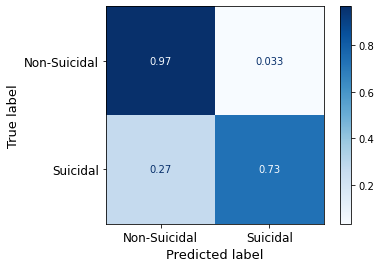

In [18]:
# confusion matrix values

tn, fp, fn, tp = confusion_matrix(y_test, test_pred).ravel()

# plot confusion matrix

labels = ['Non-Suicidal', 'Suicidal']

plot_confusion_matrix(svc, test, y_test, cmap = 'Blues', normalize = 'true')
plt.xticks(ticks = [0, 1], labels = labels, size = 12)
plt.yticks(ticks = [0, 1], labels = labels, size = 12)
plt.xlabel('Predicted label', size = 13)
plt.ylabel('True label', size = 13);

In [22]:
# classification report

print(classification_report(y_test, test_pred, target_names = labels))

              precision    recall  f1-score   support

Non-Suicidal       0.93      0.97      0.95     24327
    Suicidal       0.85      0.73      0.79      6285

    accuracy                           0.92     30612
   macro avg       0.89      0.85      0.87     30612
weighted avg       0.92      0.92      0.92     30612

